In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
from tensorflow import keras

In [4]:
with open("/content/drive/My Drive/Colab Notebooks/dane.json", 'r') as data:
    patents = json.load(data)

In [ ]:
#patents[:1]

In [5]:
abstract_key='description'

In [8]:
a61m_cathegory_count=0
b65d_cathegory_count=0
no_cathegory_count=0
words_count_list=[]
for patent in patents:
    words_count_list.append(len(patent[abstract_key].split()) )
    if (patent['classification']['main'][:4] == 'A61M'):
        a61m_cathegory_count+=1
    elif(patent['classification']['main'][:4] == 'B65D'):
        b65d_cathegory_count+=1
    else:
        no_cathegory_count+=1

In [11]:
#AD.EDA
# 1. Check how many patents we have.
patents_count=len(patents)
print("The number of patents is equal to", patents_count)

#2.
#dane[:0] # JSON składa się z 7 kolumn.

#3. Check if patents were counted into cathegories properly. There shouldn't be any patent witohut the cathegory.
print(no_cathegory_count)
print(f"There are {a61m_cathegory_count} patents in the A61M cathegory and {b65d_cathegory_count} in the B65D cathegory. Classes are not equidistant.")

The number of patents is equal to 11433
0
There are 5434 patents in the A61M cathegory and 5999 in the B65D cathegory. Classes are not equidistant.


In [12]:
print(words_count_list) #Shows how many words are in every patent description

[1465, 1098, 953, 3444, 460, 701, 359, 459, 1878, 895, 1116, 423, 811, 443, 790, 964, 508, 2006, 1144, 1285, 681, 833, 1197, 2363, 3070, 990, 1482, 3558, 659, 819, 3320, 644, 1316, 638, 277, 3596, 1405, 1088, 1451, 1068, 1013, 1199, 678, 1953, 3162, 2929, 1095, 2411, 693, 1046, 1254, 862, 646, 1673, 972, 1164, 3687, 1132, 3312, 1181, 928, 1976, 1282, 540, 1592, 575, 1922, 1247, 1372, 769, 401, 961, 1378, 946, 1485, 1710, 1561, 977, 758, 1543, 61, 717, 1955, 578, 694, 1121, 216, 1372, 801, 1144, 1067, 1498, 544, 596, 1297, 1047, 1154, 1117, 1092, 816, 500, 335, 1013, 628, 2719, 862, 1016, 1938, 1745, 2541, 1318, 335, 731, 4813, 494, 2388, 2037, 1178, 1705, 1364, 218, 516, 1464, 1485, 973, 898, 1333, 2337, 1851, 1498, 1434, 1871, 1589, 1238, 842, 1105, 3181, 4151, 1115, 791, 736, 1288, 1745, 957, 1221, 775, 816, 884, 713, 3508, 1744, 1316, 588, 895, 425, 1546, 1946, 788, 1021, 813, 2545, 576, 1623, 1394, 1357, 1976, 1416, 655, 998, 4336, 287, 2409, 1173, 529, 878, 526, 884, 751, 2001, 21

In [13]:
word_count_mean = np.mean(words_count_list)
word_count_median = np.median(words_count_list)

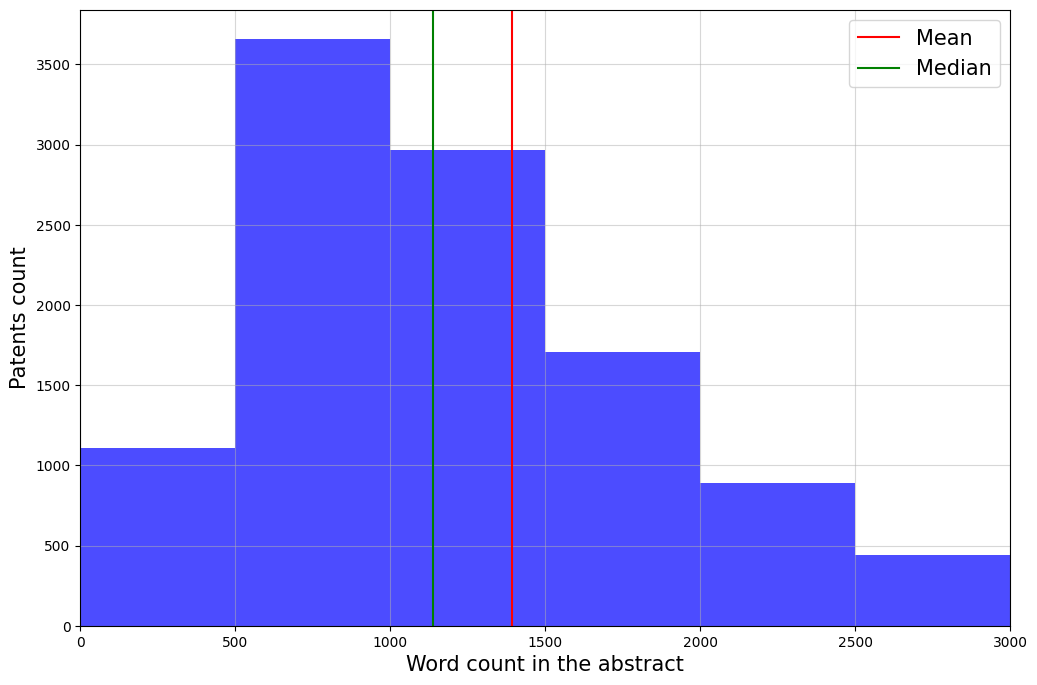

In [22]:
plt.figure(figsize = (12,8))
plt.hist(words_count_list, ls = '-', bins = [0, 500, 1000, 1500, 2000, 2500, 3000], color = 'blue', alpha = 0.7)
plt.xlabel("Word count in the abstract", fontsize=15)
plt.ylabel("Patents count", fontsize=15)
plt.xlim(0, 3000)
plt.axvline(x = word_count_mean, c = 'red', label = "Mean")
plt.axvline(x = word_count_median, c = 'green', label = "Median")
plt.legend(fontsize = 15)
plt.grid(alpha = 0.5)
plt.show()

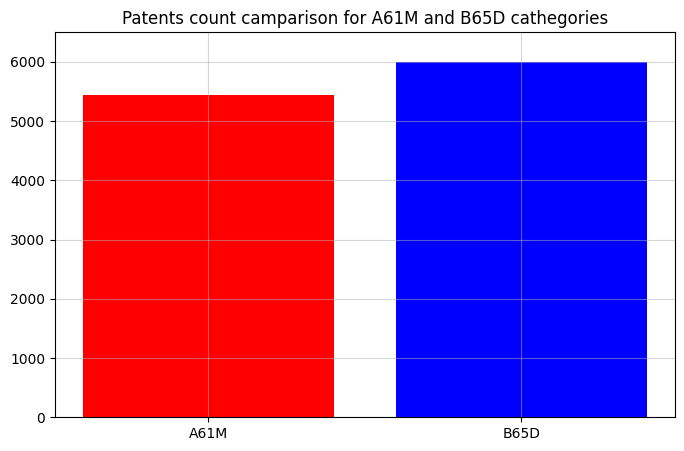

In [29]:
plt.figure(figsize=(8, 5))
plt.ylim((0, 6500))
plt.grid(alpha = 0.5)
plt.bar(("A61M", "B65D"), (5434, 5999), color=('red', 'blue'))
plt.title("Patents count camparison for A61M and B65D cathegories")
plt.show()

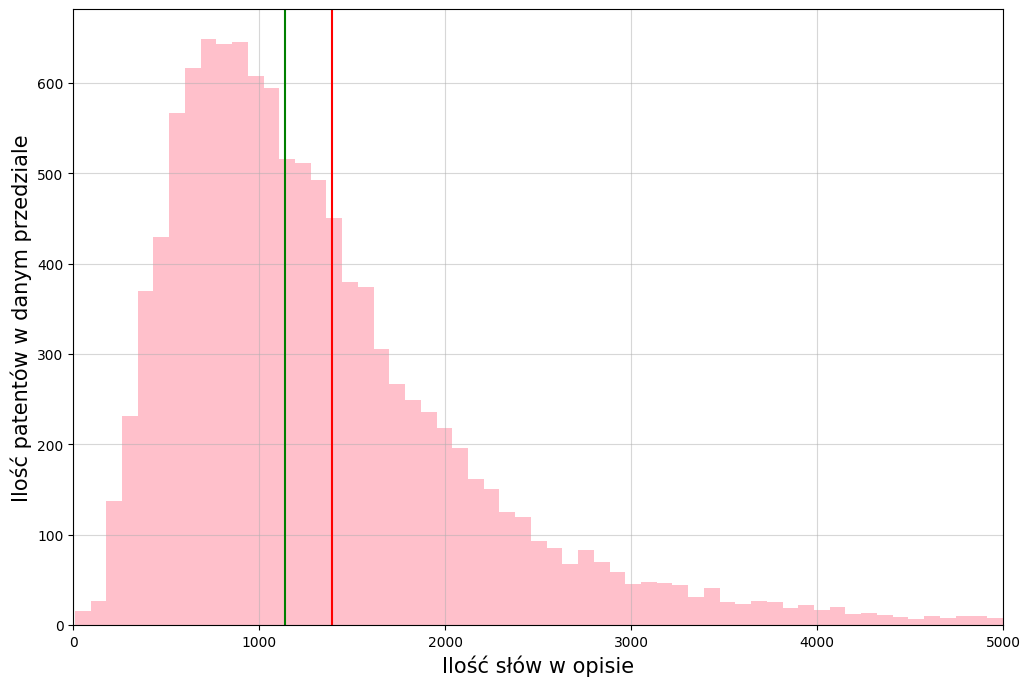

In [37]:
plt.figure(figsize = (12, 8))
plt.hist(words_count_list, ls = '-', color = 'pink', alpha = 1, bins = 'auto')
plt.xlabel("Ilość słów w opisie", fontsize = 15)
plt.ylabel("Ilość patentów w danym przedziale", fontsize = 15)
plt.xlim(0, 5000)
plt.axvline(x = word_count_mean, c = 'red')
plt.axvline(x = word_count_median, c = 'green')
plt.grid(alpha = 0.5)

plt.show()

In [38]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical
import os

In [40]:
labels = []
for patent in patents:
    patent_cathegory = patent['classification']['main'][0:4]
    if patent_cathegory.startswith('A61M'):
      labels.append([1,0])
    else:
      labels.append([0,1])

In [41]:
abstracts = [patent[abstract_key] for patent in patents]

In [42]:
tokenizer  = Tokenizer()
tokenizer.fit_on_texts(abstracts) #Words to vectors library.

In [43]:
sequences = tokenizer.texts_to_sequences(abstracts)

In [44]:
word_index = tokenizer.word_index

In [45]:
#word_index

In [46]:
data_sequences = pad_sequences(sequences, maxlen = 100)

In [47]:
def split_data(data_sequences, labels, split):
    indices = np.arange(data_sequences.shape[0])
    np.random.shuffle(indices)
    data_sequences = data_sequences[indices]
    labels = labels[indices]
    nb_validation_samples = int(split * data_sequences.shape[0])

    x_train = data_sequences[:-nb_validation_samples].astype(np.float32)
    y_train = labels[:-nb_validation_samples].astype(np.float32)
    x_val = data_sequences[-nb_validation_samples:].astype(np.float32)
    y_val = labels[-nb_validation_samples:].astype(np.float32)
    return x_train, y_train, x_val, y_val

In [48]:
def train_test_data(split):
    return split_data(data_sequences, np.array(labels), split), word_index

In [49]:
TAKE_FIRST=11433

In [50]:

(x_train, y_train, x_val, y_val), word_index = train_test_data(0.5)

print('Shape of data tensor:', x_train.shape, x_val.shape)
print('Shape of label tensor:', y_train.shape, y_val.shape)

Shape of data tensor: (5717, 100) (5716, 100)
Shape of label tensor: (5717, 2) (5716, 2)


In [51]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, GlobalMaxPool1D, LSTM
from keras.metrics import categorical_accuracy

In [74]:
from pathlib import Path

def embedding_matrix(word_index):
    dim = 300
    print("Loading GloVe word vectors...")
    embeddings_index = {}
    with open("/content/drive/My Drive/Colab Notebooks/glove.42B.300d.txt") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print('Found %s word vectors.' % len(embeddings_index))

    embedding_matrix = np.zeros((len(word_index) + 1, dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [75]:
EMBEDDING_DIM = 300
emb_matrix = embedding_matrix(word_index)

Loading GloVe word vectors...
Found 1917494 word vectors.


In [76]:
from keras.layers import Embedding

def embedding_layer(x_train, word_index):
    return Embedding(len(word_index) + 1,
                     EMBEDDING_DIM,
                     weights=[emb_matrix],
                     input_length=x_train.shape[1],
                     trainable=False)

In [83]:
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, GlobalMaxPool1D, LSTM
from keras.metrics import categorical_accuracy

In [84]:
import keras.backend as kb
def sum_binary_crossentropy(y_true, y_pred):
    return kb.sum(kb.binary_crossentropy(y_true, y_pred), axis=-1)

In [90]:
def model3(embedding, n_cats):
    model = Sequential()
    model.add(embedding)
    model.add(Dropout(0.2))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(GlobalMaxPool1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(n_cats, activation='sigmoid'))

    model.compile(loss=sum_binary_crossentropy,
                  optimizer = 'adam',
                  metrics=[categorical_accuracy])

    print(model.summary())
    return model

In [91]:
early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1)

In [92]:
model = model3(embedding_layer(x_train, word_index), y_train.shape[1])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 300)          22353300  
                                                                 
 dropout_3 (Dropout)         (None, 100, 300)          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 98, 128)           115328    
                                                                 
 global_max_pooling1d_3 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 2)                 258       
                                                      

In [93]:
x_train[0,0].dtype, y_train[0,0].dtype, x_val[0,0].dtype, y_val[0,0].dtype

(dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'))

In [94]:
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=10, batch_size=32, callbacks=[early_stopping])

Epoch 1/10
179/179 [==============================] - 19s 100ms/step - loss: 0.7067 - categorical_accuracy: 0.8448 - val_loss: 0.3772 - val_categorical_accuracy: 0.9263
Epoch 2/10
179/179 [==============================] - 17s 96ms/step - loss: 0.3512 - categorical_accuracy: 0.9299 - val_loss: 0.3476 - val_categorical_accuracy: 0.9311
Epoch 3/10
179/179 [==============================] - 15s 85ms/step - loss: 0.2662 - categorical_accuracy: 0.9489 - val_loss: 0.3398 - val_categorical_accuracy: 0.9339
Epoch 4/10
179/179 [==============================] - 16s 87ms/step - loss: 0.1966 - categorical_accuracy: 0.9650 - val_loss: 0.3434 - val_categorical_accuracy: 0.9360
Epoch 4: early stopping


# Validation

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import pandas as pd
import numpy as np
import os

sns.set(color_codes=True)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [96]:
def total_recall_precision(p, y, t):
    p_mask = np.zeros_like(p).astype(bool)
    y_mask = y.astype(bool)
    p_mask[p >= t] = True
    p = np.sum(p_mask & y_mask)
    n = np.sum(p_mask & ~y_mask)
    true = np.sum(y_mask)
    return (p/true, p/(p+n) if p+n>0 else 0)

def plot_total_recall_precision(model, x, y):
    pred = model.predict(x)
    ts = np.linspace(0, 1, 50)
    recall, prec = zip(*[total_recall_precision(pred, y, t) for t in ts])
    plt.plot(ts, recall, label="recall")
    plt.plot(ts, prec, label="precission")
    plt.legend()
    plt.show()

In [97]:
pred_val = model.predict(x_val)

179/179 [==============================] - 4s 20ms/step


179/179 [==============================] - 5s 30ms/step


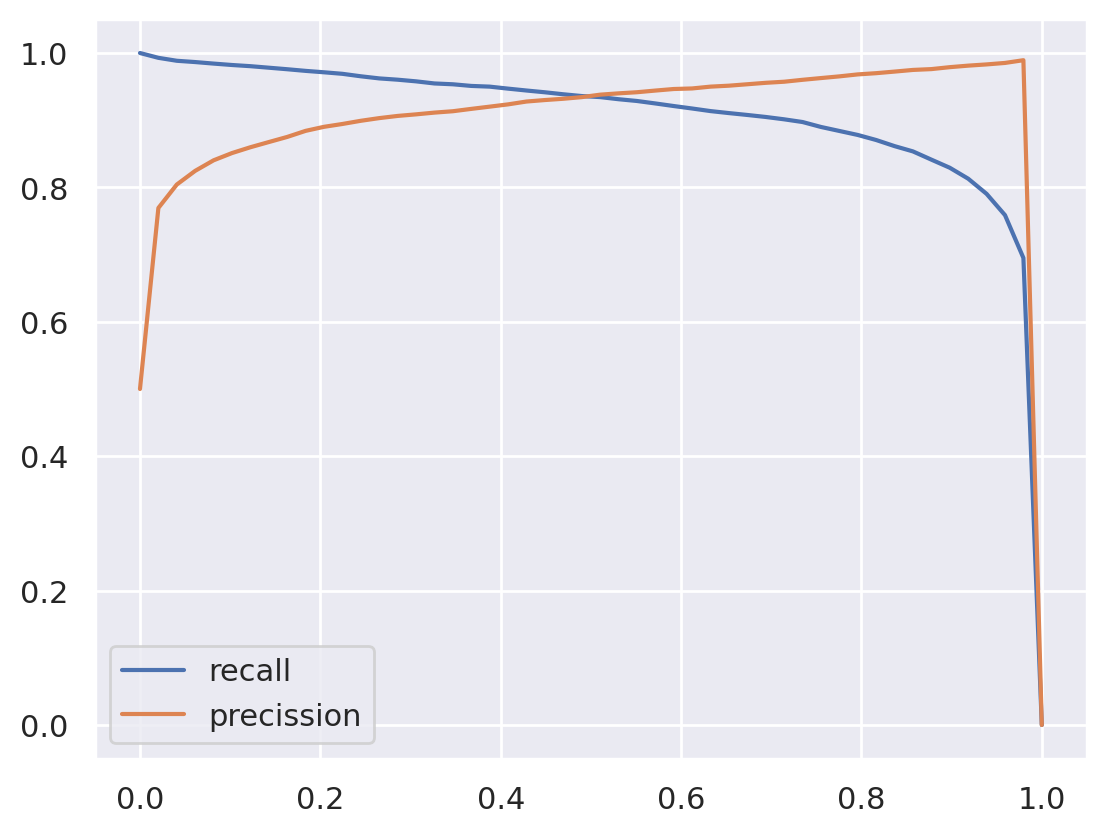

In [98]:
plot_total_recall_precision(model, x_val, y_val)

In [112]:
pred_val[100]

array([0.02596341, 0.96969   ], dtype=float32)

In [113]:
x_val[0]

array([4.790e+02, 6.720e+02, 5.000e+00, 1.000e+00, 4.600e+02, 3.100e+01,
       1.740e+02, 1.723e+03, 1.800e+01, 1.000e+00, 1.100e+02, 1.960e+02,
       2.000e+00, 1.000e+00, 4.790e+02, 1.700e+01, 1.650e+02, 3.900e+01,
       5.130e+02, 5.200e+01, 6.000e+00, 2.177e+03, 2.500e+01, 1.000e+00,
       9.800e+01, 1.900e+01, 1.000e+00, 2.700e+01, 4.160e+02, 1.000e+00,
       4.790e+02, 6.720e+02, 5.000e+00, 9.000e+00, 1.000e+00, 4.600e+02,
       3.100e+01, 7.676e+03, 2.688e+03, 1.100e+01, 4.600e+02, 7.400e+01,
       5.900e+01, 1.000e+00, 9.800e+01, 8.020e+02, 5.000e+00, 1.000e+00,
       1.780e+02, 3.100e+01, 1.500e+01, 4.000e+02, 1.000e+00, 6.500e+01,
       2.000e+00, 2.044e+03, 1.610e+02, 2.000e+00, 1.000e+00, 4.940e+02,
       7.000e+00, 3.000e+00, 1.114e+03, 8.700e+01, 2.000e+00, 1.000e+00,
       1.300e+01, 1.000e+00, 2.537e+03, 1.780e+02, 3.100e+01, 6.000e+00,
       1.940e+02, 5.160e+02, 4.000e+00, 1.000e+00, 2.700e+01, 5.000e+00,
       3.000e+00, 1.620e+02, 5.950e+02, 2.410e+02, 

In [114]:
y_val[0]

array([0., 1.], dtype=float32)